In [33]:
%matplotlib widget
# setup the environment 
import pandas as pd
import numpy as np
import statsmodels.stats.api as sms # for confidence intervals
from scipy.stats import sem # another confidence interval shorthand 
import matplotlib.cm as cm
import matplotlib.colors as col
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1.inset_locator as mpl_il
from matplotlib.widgets import Button, Slider
# from matplotlib.ticker import FormatStrFormatter, ScalarFormatter

class interactiveBarChart:
    """
    A base class that can be used for creating clicable charts and solving
    the challenges of interpreting plots with confidence intervals.
    """
    # basic greys: lighter for regular, darker for emphasis
    greys = ['#afafaf','#7b7b7b'] # ticks and boxes, arrows, legend ticks and text
    # horizontal bar: nice red
    horzo_bar = '#004a80'
    # set bar colormap
    cmap = cm.get_cmap('RdBu')
    cpick = cm.ScalarMappable(cmap=cmap)
    cpick.set_array(np.linspace(-1, 1))

    # instantiate the class
    def __init__(self): 
        """
        Initialize the data and a new figure.
        """
        # seed for data.
        np.random.seed(12345)
        # get some data to plot
        self.df = pd.DataFrame(np.c_[np.random.normal(33500,150000,3650), # np.c_ class to transpose array
                   np.random.normal(41000,90000,3650), 
                   np.random.normal(41000,120000,3650), 
                   np.random.normal(48000,55000,3650)], 
                  columns=[1992,1993,1994,1995])
        # get mean values to plot
        self.means = self.df.mean()        
        # calculate confidence interval high and low
        self.c_i = [ sms.DescrStatsW(self.df[i]).tconfint_mean() for i in self.df.columns ]
        # calculate the interval whole number
        self.intervals = [ invl[-1] - invl[0] for invl in self.c_i ] 

        # plot the bar chart and make a reference to the rectangles
        self.rects = plt.bar(
            range(len(self.df.columns)), 
            self.means,
            yerr=self.df.sem().values*1.96,
            align='center', 
            alpha=0.8, 
            color=self.greys[0],
            error_kw=dict(ecolor='gray', lw=2, capsize=7, capthick=2)
        )

        # set up a starting axhline
        self.horzo_slider = plt.axhline(y=40000, xmin=-.1, clip_on=False, zorder=1, color='#e82713')

        ## TICKS AND TEXT AND SPINES
        plt.title('Confidence Interval Interactivity: Click the Chart To Recolor', color=self.greys[1])
        plt.xticks(range(len(self.df.columns)), self.df.columns)        
        # do some formatting 
        self.formatArtists(plt.gca())


        ## EVENT HANDLING
        # reference the axes and setup pick events
        plt.gcf().canvas.mpl_connect('button_press_event', self.setAxHLine)


    def formatArtists(self, ax):
        """
        Does some recoloring and formatting of the ticks, labels, and spines.
        Receives the axes of the current figure.
        """
        # recolor the ticks
        ax.xaxis.set_tick_params(which='major', colors=self.greys[1])
        ax.yaxis.set_tick_params(which='major', colors=self.greys[1])

        # recolor the spines
        for pos in ['top', 'right', 'bottom', 'left']:
            ax.spines[pos].set_edgecolor(self.greys[0])
        
    ## EVENT HANDLERS
    def setAxHLine(self, event): 
        """
        Handle the logic for handling bar coloring when the slider 
        is moved up or down over the confidence intervals.
        """
        # remove first axhline
        self.horzo_slider.remove()
        self.horzo_slider = plt.axhline(y=event.ydata, xmin=-.1, clip_on=False, zorder=1, color='#e82713')
        #self.recolorBars(event)
        
    def recolorBars(self, event):      
        y = event.ydata
        for i, rect in enumerate(self.rects):
            t, p, _ = sms.DescrStatsW(self.df[self.df.columns[i]]).ttest_mean(y)
            rect.set_color(self.cpick.to_rgba((1 - p) * t / abs(t)))

    def showPlot(self):
        plt.show()

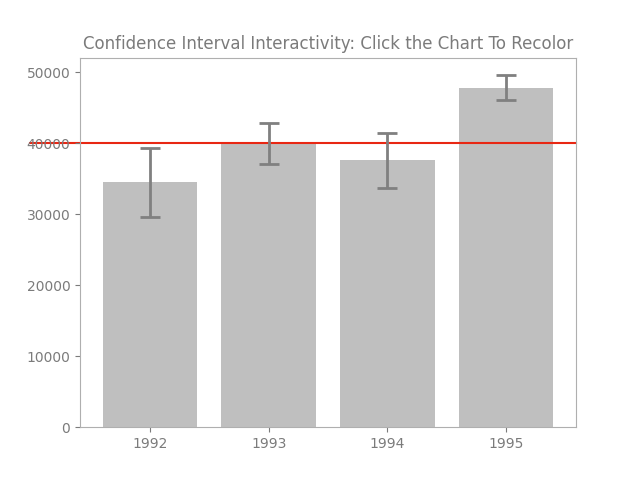

In [34]:
interactiveBarChart()

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

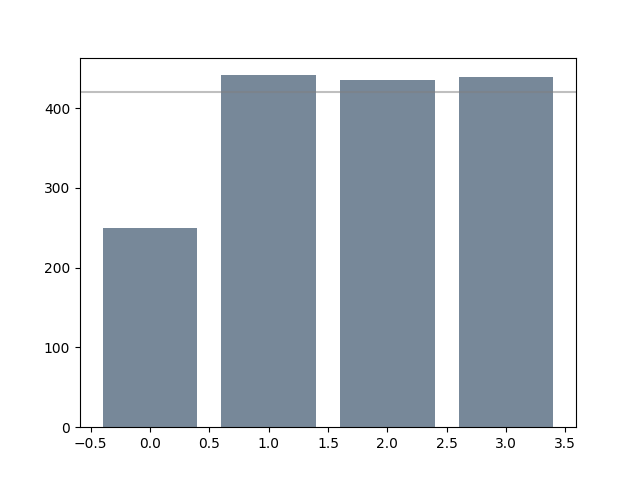

In [35]:
import pandas as pd
import numpy as np
import matplotlib.colors as mcol
import matplotlib.cm as cm
import matplotlib.pyplot as plt

np.random.seed(12345)
df = pd.DataFrame([np.random.normal(335,1500,300), 
                   np.random.normal(410,900,300), 
                   np.random.normal(410,1200,300), 
                   np.random.normal(480,550,300)], 
                  index=[1992,1993,1994,1995])

fig, ax = plt.subplots()

threshold = 420.
bars = plt.bar(range(df.shape[0]), df.mean(axis = 1), color = 'lightslategrey')
axline = plt.axhline(y = threshold, color = 'grey', alpha = 0.5)

cm1 = mcol.LinearSegmentedColormap.from_list("Test",["b", "white", "purple"])
cpick = cm.ScalarMappable(cmap=cm1) 
cpick.set_array([])
plt.colorbar(cpick, orientation='horizontal')

def percentages(threshold):
    percentages = []
    for bar in bars:
        percentage = (bar.get_height()-threshold)/bar.get_height()
        if percentage>1: percentage = 1
        if percentage<0: percentage=0
        percentages.append(percentage)
    return percentages

def update(threshold):
    axline.set_ydata(threshold)
    perc = percentages(threshold)
    for bar, p in zip(bars, perc):
        bar.set_color(cpick.to_rgba(p))

# update once before showing
update(threshold)

def onMouseMove(event):
    if event.inaxes == ax:
        update(event.ydata)
        fig.canvas.draw_idle()

fig.canvas.mpl_connect('motion_notify_event', onMouseMove)

plt.xticks(range(df.shape[0]), df.index, alpha = 0.8)

plt.show()